# The Haunted DAG & The Causal Terror

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from causalgraphicalmodels import CausalGraphicalModel
%matplotlib inline

In [3]:
import statsutils

In [4]:
sns.set()

### 6.1

In [5]:
np.random.seed(1914)
N = 200
p = 0.1
nw = stats.norm.rvs(size=N)
tw = stats.norm.rvs(size=N)
s = nw + tw
q = np.quantile(s, 1-p)
selected = s >= q
np.corrcoef(tw[selected], nw[selected])

array([[ 1.        , -0.64839295],
       [-0.64839295,  1.        ]])

## Multicollinearity

### 6.2

In [6]:
N = 100
np.random.seed(909)
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height, 
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 6.3

In [7]:
with pm.Model() as m6_1:
    sigma = pm.Exponential("sigma", lam=1.0)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_6_1 = pm.sample()
    
pm.summary(trace_6_1, var_names=["a", "bl", "br", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [01:02<00:00, 64.06draws/s] 
The acceptance probability does not match the target. It is 0.894486444441349, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.813,0.555,4.959,6.764,0.016,0.011,1252.0,1244.0,1253.0,1195.0,1.0
bl,-7.215,4.169,-13.124,0.004,0.173,0.122,584.0,584.0,590.0,698.0,1.0
br,7.853,4.162,0.535,13.629,0.172,0.122,583.0,583.0,589.0,683.0,1.0
sigma,1.547,0.114,1.364,1.727,0.004,0.003,953.0,948.0,928.0,968.0,1.0


### 6.4

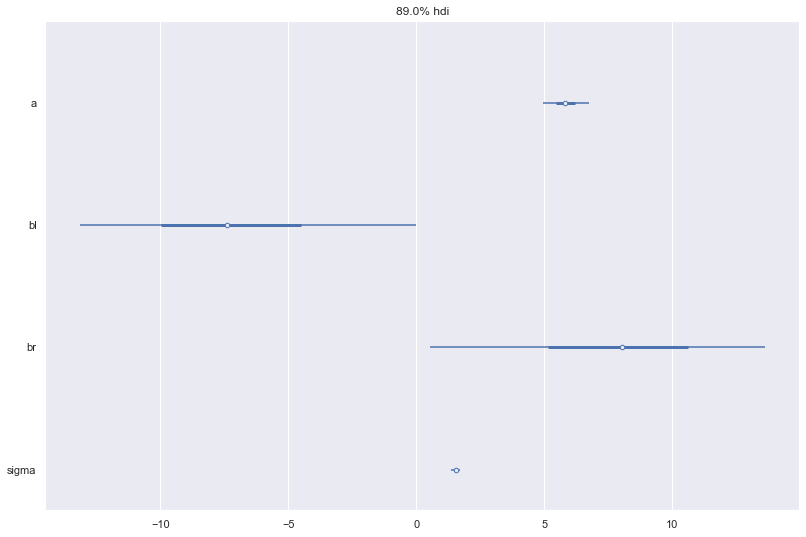

In [8]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
pm.forestplot(trace_6_1, hdi_prob=0.89, ax=ax, var_names=["a", "bl", "br", "sigma"], combined=True);

### 6.5

100%|██████████| 1000/1000 [00:00<00:00, 13993.28it/s]


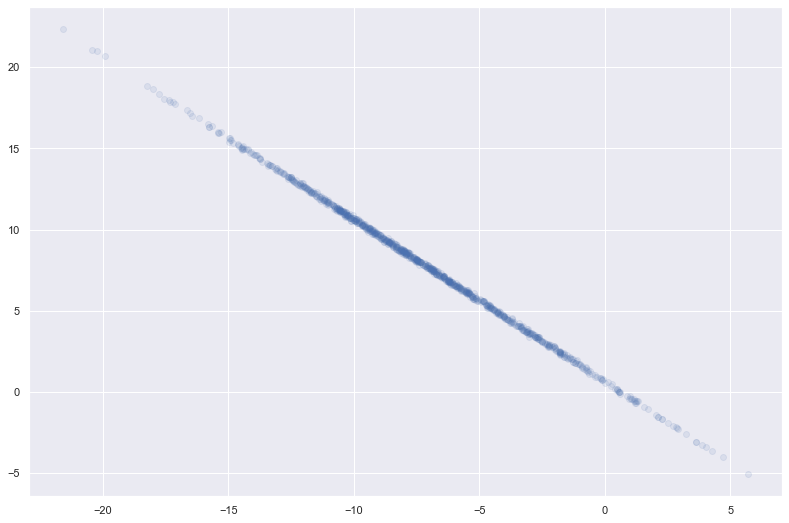

In [9]:
post = pm.sample_posterior_predictive(trace_6_1, 1000, m6_1, var_names=["bl", "br"])
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
ax.scatter(post["bl"], post["br"], alpha=0.1);

### 6.6

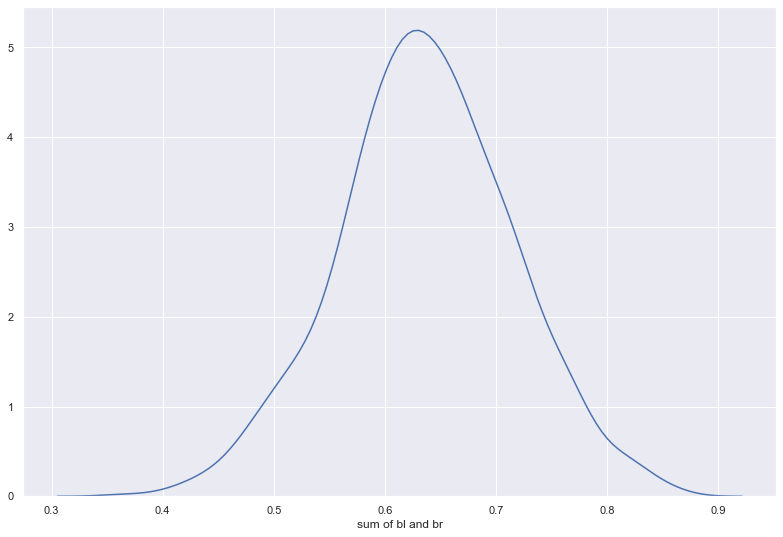

In [10]:
sum_blbr = post["bl"] + post["br"]
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
sns.kdeplot(sum_blbr)
ax.set_xlabel("sum of bl and br");

### 6.7

In [11]:
with pm.Model() as m6_2:
    sigma = pm.Exponential("sigma", lam=1.0)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_6_2 = pm.sample()
    
pm.summary(trace_6_2, var_names=["a", "bl", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1992.80draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.663,0.559,4.761,6.479,0.019,0.014,840.0,840.0,852.0,746.0,1.0
bl,0.657,0.079,0.522,0.774,0.003,0.002,841.0,828.0,855.0,768.0,1.0
sigma,1.579,0.118,1.390,1.749,0.004,0.003,957.0,946.0,970.0,716.0,1.0


### 6.8

In [12]:
d = (pd.read_csv('Data/milk.csv', sep=';')
     .assign(K=lambda df: statsutils.standardise(df["kcal.per.g"]))
     .assign(F=lambda df: statsutils.standardise(df["perc.fat"]))
     .assign(L=lambda df: statsutils.standardise(df["perc.lactose"])))

### 6.9

In [13]:
with pm.Model() as m6_3:
    sigma = pm.Exponential("sigma", lam=1.0)
    bF = pm.Normal("bF", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bF*d["F"])
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])
    trace_6_3 = pm.sample()
    
with pm.Model() as m6_4:
    sigma = pm.Exponential("sigma", lam=1.0)
    bL = pm.Normal("bL", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bL*d["L"])
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])
    trace_6_4 = pm.sample()
    
print(pm.summary(trace_6_3, var_names=["a", "bF", "sigma"], hdi_prob=0.89)
      [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])
print(pm.summary(trace_6_4, var_names=["a", "bL", "sigma"], hdi_prob=0.89)
      [["mean", "sd", "hdi_5.5%", "hdi_94.5%"]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3709.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bL, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3815.09draws/s]


        mean     sd  hdi_5.5%  hdi_94.5%
a      0.003  0.084    -0.123      0.142
bF     0.856  0.094     0.717      1.008
sigma  0.487  0.069     0.386      0.595
        mean     sd  hdi_5.5%  hdi_94.5%
a      0.001  0.075    -0.118      0.124
bL    -0.899  0.075    -1.029     -0.788
sigma  0.412  0.057     0.323      0.495


### 6.10

In [14]:
with pm.Model() as m6_5:
    sigma = pm.Exponential("sigma", lam=1.0)
    bL = pm.Normal("bL", mu=0, sd=0.5)
    bF = pm.Normal("bF", mu=0, sd=0.5)
    a = pm.Normal("a", mu=0, sd=0.2)
    mu = pm.Deterministic("mu", a + bF*d["F"] + bL*d["L"])
    K = pm.Normal("K", mu=mu, sd=sigma, observed=d["K"])
    trace_6_5 = pm.sample()
    
pm.summary(trace_6_5, var_names=["a", "bL", "bF", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1950.36draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.072,-0.121,0.112,0.002,0.002,1227.0,672.0,1246.0,845.0,1.00
bL,-0.658,0.197,-0.963,-0.338,0.007,0.005,845.0,845.0,847.0,843.0,1.01
bF,0.260,0.194,-0.042,0.560,0.007,0.005,865.0,814.0,869.0,950.0,1.01
sigma,0.413,0.061,0.320,0.505,0.002,0.001,1068.0,1068.0,1057.0,1174.0,1.01


### 6.11

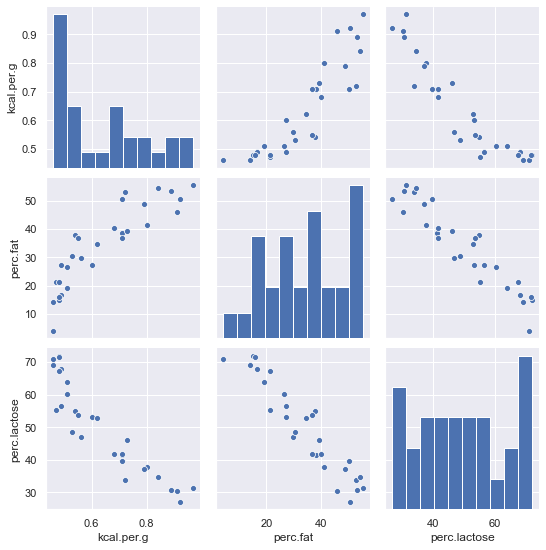

In [15]:
sns.pairplot(d[["kcal.per.g", "perc.fat", "perc.lactose"]]);

### 6.12

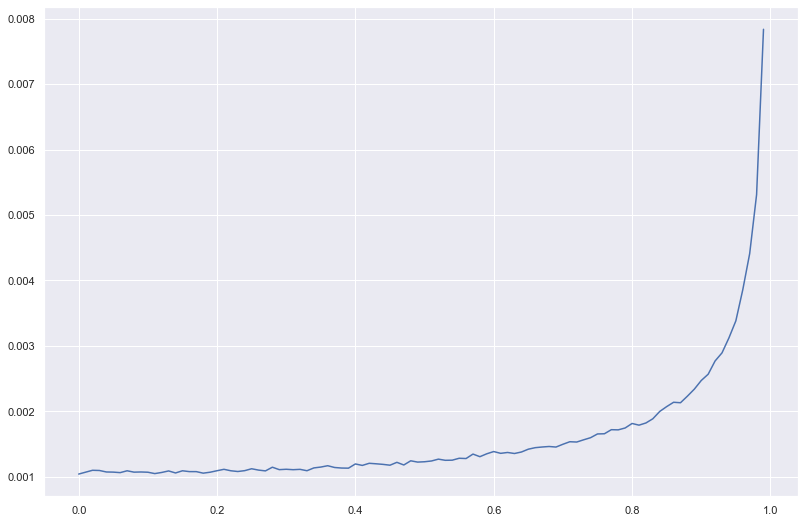

In [16]:
d = (pd.read_csv('Data/milk.csv', sep=';')
     .rename(columns={"kcal.per.g": "kcal",
                      "perc.fat": "fat"}))

def sim_coll(r=0.9):
    x = stats.norm.rvs(r*d["fat"], np.sqrt((1-r**2)*np.var(d["fat"])))
    m = smf.ols("kcal ~ fat + x", data=d.assign(x=x)).fit()
    return np.sqrt(np.diag(m.cov_params())[-1])

def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for _ in range(n)])

r_seq = np.arange(0, 1, 0.01)
stddev = [rep_sim_coll(r) for r in r_seq]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9);
ax.plot(r_seq, stddev);

## Post-Treatment Bias

### 6.13

In [17]:
np.random.seed(71)
N = 100
h0 = stats.norm.rvs(10, 2, N)
treatment = np.concatenate([np.zeros(N//2), np.ones(N//2)])
fungus = stats.binom.rvs(p=0.5 - 0.4*treatment, n=1)
h1 = h0 + stats.norm.rvs(5-3*fungus, 1, N)
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})
d.describe()

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,10.151728,14.492661,0.500000,0.280000
std,1.667146,2.452841,0.502519,0.451261
min,6.087715,7.294385,0.000000,0.000000
25%,9.045405,12.737115,0.000000,0.000000
50%,10.117129,14.733176,0.500000,0.000000
75%,11.368423,16.260289,1.000000,1.000000
max,13.885944,20.043991,1.000000,1.000000


### 6.14

In [18]:
sim_p = pd.Series(stats.lognorm.rvs(s=0.25, scale=np.exp(0), size=int(1e4)))
sim_p.describe()

count    10000.000000
mean         1.032948
std          0.262636
min          0.392093
25%          0.845103
50%          1.000914
75%          1.182711
max          2.830848
dtype: float64

### 6.15

In [19]:
with pm.Model() as m6_6:
    sigma = pm.Exponential("sigma", lam=1.0)
    p = pm.Lognormal("p", mu=0, sigma=0.25)
    mu = pm.Deterministic("mu", p*d["h0"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_6_6 = pm.sample()
    
pm.summary(trace_6_6, var_names=["p", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4002.99draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.417,0.019,1.388,1.446,0.000,0.000,1904.0,1904.0,1906.0,1330.0,1.0
sigma,1.885,0.138,1.663,2.092,0.004,0.002,1536.0,1536.0,1513.0,1228.0,1.0


### 6.16

In [20]:
with pm.Model() as m6_7:
    sigma = pm.Exponential("sigma", lam=1.0)
    bf = pm.Normal("bf", 0, 0.5)
    bt = pm.Normal("bt", 0, 0.5)    
    a = pm.Lognormal("a", mu=0, sigma=0.2)
    p = pm.Deterministic("p", a + bt*d["treatment"] + bf*d["fungus"])
    mu = pm.Deterministic("mu", p*d["h0"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_6_7 = pm.sample()
    
pm.summary(trace_6_7, var_names=["a", "sigma", "bf", "bt"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2411.22draws/s]
The acceptance probability does not match the target. It is 0.8816800526220084, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.513,0.022,1.479,1.548,0.001,0.001,952.0,952.0,953.0,1022.0,1.0
sigma,1.254,0.091,1.105,1.394,0.003,0.002,1241.0,1217.0,1267.0,1093.0,1.0
bf,-0.312,0.030,-0.362,-0.267,0.001,0.001,985.0,985.0,984.0,1328.0,1.0
bt,-0.018,0.027,-0.061,0.027,0.001,0.001,987.0,987.0,989.0,969.0,1.0


### 6.17

In [21]:
with pm.Model() as m6_8:
    sigma = pm.Exponential("sigma", lam=1.0)
    bt = pm.Normal("bt", 0, 0.5)    
    a = pm.Lognormal("a", mu=0, sigma=0.2)
    p = pm.Deterministic("p", a + bt*d["treatment"])
    mu = pm.Deterministic("mu", p*d["h0"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_6_8 = pm.sample()
    
pm.summary(trace_6_8, var_names=["a", "sigma", "bt"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2845.30draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.362,0.026,1.321,1.403,0.001,0.001,1008.0,1006.0,1019.0,1049.0,1.0
sigma,1.827,0.130,1.614,2.017,0.004,0.003,1091.0,1067.0,1136.0,1197.0,1.0
bt,0.103,0.036,0.049,0.164,0.001,0.001,1049.0,1049.0,1049.0,987.0,1.0


### 6.18

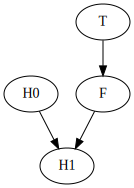

In [22]:
plant_dag = CausalGraphicalModel(
                nodes=["H0", "H1", "F", "T"],
                edges=[("H0", "H1"),
                       ("F", "H1"),
                       ("T", "F")])

# graphviz needed on the system
plant_dag.draw()

### 6.19

In [23]:
statsutils.implied_conditional_independencies(plant_dag)

[('H0', 'F', set()), ('H0', 'T', set()), ('H1', 'T', {'F'})]

### 6.20

In [24]:
np.random.seed(71)
N = 1000
h0 = stats.norm.rvs(10, 2, N)
treatment = np.concatenate([np.zeros(N//2), np.ones(N//2)])
M = stats.bernoulli.rvs(size=N, p=0.5)
fungus = stats.binom.rvs(p=0.5 - 0.4*treatment + 0.4*M, n=1)
h1 = h0 + stats.norm.rvs(5+3*M, 1, N)
d2 = pd.DataFrame({"h0": h0,
                   "h1": h1,
                   "treatment": treatment,
                   "fungus": fungus})

## Collider Bias

taken from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb)

In [25]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = (
            np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        )
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

### 6.21

In [26]:
d = (sim_happiness(seed=1977, N_years=1000)
     .astype({"married": int}))
d.describe()

,age,happiness,married
count,1300.000000,1.300000e+03,1300.000000
mean,32.000000,-1.004325e-16,0.276154
std,18.768883,1.214421e+00,0.447266
min,0.000000,-2.000000e+00,0.000000
25%,16.000000,-1.000000e+00,0.000000
50%,32.000000,-1.110223e-16,0.000000
75%,48.000000,1.000000e+00,1.000000
max,64.000000,2.000000e+00,1.000000


### 6.22

In [27]:
d2 = d[d["age"] > 17]
d2["A"] = (d2["age"] - 18)/(65-18)

### 6.23

In [28]:
with pm.Model() as m6_9:
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sigma=2)
    a = pm.Normal("a", mu=0, sigma=1, shape=2)
    mu = pm.Deterministic("mu", a[d2["married"]] + bA*d2["A"])
    happiness = pm.Normal("happiness", mu=mu, sd=sigma, observed=d2["happiness"])
    trace_6_9 = pm.sample()
    
pm.summary(trace_6_9, var_names=["a", "sigma", "bA"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1685.54draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.222,0.067,-0.341,-0.123,0.002,0.002,791.0,791.0,791.0,1145.0,1.0
a[1],1.274,0.090,1.131,1.424,0.003,0.002,764.0,754.0,771.0,880.0,1.0
sigma,0.996,0.022,0.960,1.030,0.001,0.000,1306.0,1300.0,1329.0,1207.0,1.0
bA,-0.714,0.122,-0.902,-0.516,0.005,0.003,728.0,705.0,733.0,983.0,1.0


### 6.24

In [29]:
with pm.Model() as m6_10:
    sigma = pm.Exponential("sigma", lam=1.0)
    bA = pm.Normal("bA", mu=0, sigma=2)
    a = pm.Normal("a", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + bA*d2["A"])
    happiness = pm.Normal("happiness", mu=mu, sd=sigma, observed=d2["happiness"])
    trace_6_10 = pm.sample()
    
pm.summary(trace_6_10, var_names=["a", "sigma", "bA"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2518.75draws/s]
The acceptance probability does not match the target. It is 0.8904151677392951, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.006,0.077,-0.111,0.132,0.003,0.002,873.0,751.0,877.0,962.0,1.0
sigma,1.215,0.028,1.171,1.259,0.001,0.001,1156.0,1156.0,1160.0,1166.0,1.0
bA,-0.010,0.134,-0.235,0.194,0.004,0.003,910.0,739.0,911.0,952.0,1.0


### 6.25

In [30]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

### 6.26

In [31]:
np.random.seed(1)
U = stats.bernoulli.rvs(p=0.5, size=N)
G = stats.norm.rvs(size=N)
P = stats.norm.rvs(b_GP*G + b_U*U, size=N)
C = stats.norm.rvs(b_PC*P + b_GC*G + b_U*U)
d = pd.DataFrame({"C": C, "P": P, "G": G, "U": U})

### 6.27

In [32]:
with pm.Model() as m6_11:
    sigma = pm.Exponential("sigma", lam=1.0)
    b_GC = pm.Normal("b_GC", mu=0, sigma=1)
    b_PC = pm.Normal("b_PC", mu=0, sigma=1)
    a = pm.Normal("a", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + b_PC*d["P"] + b_GC*d["G"])
    C = pm.Normal("C", mu=mu, sd=sigma, observed=d["C"])
    trace_6_11 = pm.sample()
    
pm.summary(trace_6_11, var_names=["a", "b_PC", "b_GC", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2503.34draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.435,0.108,0.266,0.608,0.003,0.002,1175.0,1175.0,1174.0,1275.0,1.0
b_PC,1.568,0.063,1.470,1.667,0.002,0.001,1005.0,1005.0,1002.0,1372.0,1.0
b_GC,-0.508,0.099,-0.671,-0.356,0.003,0.002,1198.0,1198.0,1203.0,1559.0,1.0
sigma,1.210,0.061,1.104,1.301,0.002,0.001,1457.0,1457.0,1449.0,1336.0,1.0


### 6.28

In [33]:
with pm.Model() as m6_12:
    sigma = pm.Exponential("sigma", lam=1.0)
    b_U = pm.Normal("b_U", mu=0, sigma=1)
    b_GC = pm.Normal("b_GC", mu=0, sigma=1)
    b_PC = pm.Normal("b_PC", mu=0, sigma=1)
    a = pm.Normal("a", mu=0, sigma=1)
    mu = pm.Deterministic("mu", a + b_PC*d["P"] + b_GC*d["G"] + b_U*d["U"])
    C = pm.Normal("C", mu=mu, sd=sigma, observed=d["C"])
    trace_6_12 = pm.sample()
    
pm.summary(trace_6_12, var_names=["a", "b_PC", "b_GC", "b_U", "sigma"], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, b_U, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2161.08draws/s]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.013,0.106,-0.141,0.187,0.003,0.002,1610.0,970.0,1615.0,1429.0,1.0
b_PC,1.168,0.073,1.049,1.281,0.002,0.002,985.0,985.0,992.0,1195.0,1.0
b_GC,-0.071,0.102,-0.229,0.087,0.003,0.002,1088.0,1088.0,1101.0,1022.0,1.0
b_U,1.636,0.194,1.359,1.973,0.006,0.004,991.0,952.0,997.0,1147.0,1.0
sigma,1.033,0.053,0.949,1.116,0.001,0.001,1695.0,1685.0,1697.0,1284.0,1.0


## Confronting Confounding

### 6.29

In [34]:
dag_6_1 = CausalGraphicalModel(
            nodes=["U", "X", "Y", "A", "C", "B"],
            edges=[("X", "Y"),
                   ("U", "X"),
                   ("A", "U"),
                   ("A", "C"),
                   ("C", "Y"),
                   ("U", "B"),
                   ("C", "B")])

statsutils.adjustment_sets(dag_6_1, "X", "Y")

[frozenset({'A'}), frozenset({'C'})]

### 6.30

In [35]:
dag_6_2 = CausalGraphicalModel(
            nodes=["A", "D", "M", "S", "W"],
            edges=[("A", "D"),
                   ("A", "M"),
                   ("M", "D"),
                   ("S", "A"),
                   ("S", "M"),
                   ("S", "W"),
                   ("W", "D")])

statsutils.adjustment_sets(dag_6_2, "W", "D")

[frozenset({'A', 'M'}), frozenset({'S'})]

### 6.31

In [36]:
statsutils.implied_conditional_independencies(dag_6_2)

[('A', 'W', {'S'}), ('D', 'S', {'A', 'M', 'W'}), ('W', 'M', {'S'})]